## Chapter 3 The Linear Model

### Part 1:Exercise

#### Exercise 3.1 (Page 79)

Will PLA ever stop updating if the data is not linearly separable?   

如果数据不是线性可分的，那么PLA不会终止，因为PLA每次挑选一个错分的数据做更新。

#### Exercise 3.2 (Page 80)

Take $d = 2$ and create a data set $\mathcal{D}$ of size $N = 100$ that is not linearly separable. You can do so by first choosing a random line in the plane as your target function and the inputs $x_n$ of the data set as random points in the plane. Then, evaluate the target function on each $x_n$ to get the corresponding output $y_n$. Finally, flip the labels of $\frac N {10}$ randomly selected $y_n$'s and the data set will likely become non separable.

Now, try the pocket algorithm on your data set using $T= 1 , 000$ iterations. Repeat the experiment 20 times. Then, plot the average $E_{in}(w(t))$ and the average $E_{in} (\hat w) $(which is also a function of t) on the same figure and see how they behave when $t$ increases. Similarly, use a test set of size 1, 000 and plot a figure to show how $E_{out} (w(t))$ and $E_{out} (\hat w) $ behave.    

首先构造100个线性不可分的点，题目给出的方法是先随意取一条直线（这里我们选择的直线是$y=x$），然后根据这条直线给出$N=100$个线性可分的点，再随机挑选其中$\frac N {10}=10$个数据，翻转他们的$y_n$，然后使用pocket PLA进行1000次迭代，画出$E_{in}(w(t))$，以及平均值$E_{in} (\hat w) $随迭代次数的变化，在这个过程中同样计算1000个测试数据的$E_{out} (w(t))$ 和平均值 $E_{out} (\hat w) $ 并作图，这里的测试数据和之前的数据符合的规则应该一致，都是同样有10%的数据经过翻转。

In [11]:
import numpy as np

#产生n组数据，10%为噪声，这里直线选择为y=x
def generatedata(n):
    #记录全部数据
    Data=[]
    for i in range(n):
        data=np.array(1)
        data=np.append(data,np.random.uniform(-2,2,2))
        if data[2]>data[1]:
            data=np.append(data,1)
        else:
            data=np.append(data,-1)
        #我们将前n/10个数据修改为噪声，最后再打乱数据
        if i<n/10:
            data[-1]*=-1
        Data.append(data)
    np.random.shuffle(Data)
    return Data

产生100个以及1000的点，然后分别作图看看。

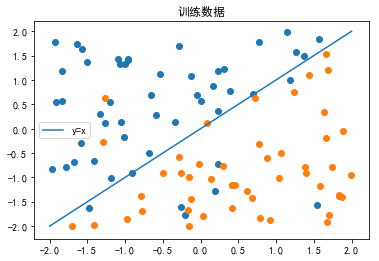

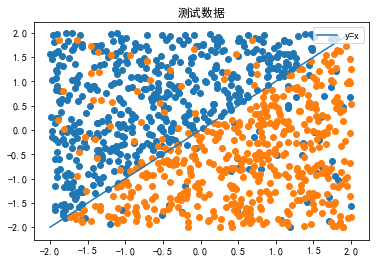

In [19]:
import matplotlib.pylab as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

#生成训练数据
train=generatedata(100)
#后面两步是为了作图
#标签为+1的点
trainpx=[i[1] for i in train if i[-1]>0]
trainpy=[i[2] for i in train if i[-1]>0]
#标签为-1的点
trainnx=[i[1] for i in train if i[-1]<0]
trainny=[i[2] for i in train if i[-1]<0]

#生成测试数据
test=generatedata(1000)
#标签为+1的点
testpx=[i[1] for i in test if i[-1]>0]
testpy=[i[2] for i in test if i[-1]>0]
#标签为-1的点
testnx=[i[1] for i in test if i[-1]<0]
testny=[i[2] for i in test if i[-1]<0]

x=[-2,2]
y=[-2,2]

#训练数据
plt.scatter(trainpx,trainpy)
plt.scatter(trainnx,trainny)
plt.title('训练数据')
plt.plot(x,y,label='y=x')
plt.legend()
plt.show()

#测试数据
plt.scatter(testpx,testpy)
plt.scatter(testnx,testny)
plt.title('测试数据')
plt.plot(x,y,label='y=x')
plt.legend()
plt.show()

接着定义Pocket PLA

In [42]:
#定义sign函数
def sign(x):
    if x>0:
        return 1
    else:
        return -1

#定义计算错误个数的函数,n为数据维度
def CountError(x,w,n):
    count=0
    for i in x:
        if sign(i[:n].dot(w))*i[-1]<0:
            count+=1
    return count

#定义PocketPLA,k为步长,max为最大更新次数
def PocketPLA(train,test,k,maxnum):
    #n为数据维度,m为数据数量
    m=len(train)
    n=len(train[0])-1
    #记录过程中的全部w
    W=[]
    #Ein
    Ein=np.array([])
    #Eout
    Eout=np.array([])
    #初始化向量
    w=np.zeros(n)
    #错误率最小的向量
    w0=np.zeros(n)
    #记录次数
    t=0
    error=CountError(train,w,n)
    if error==0:
        pass
    else:
        #记录取哪个元素
        j=0
        while (t<maxnum or error==0):
            #记录是否更新过
            flag=0
            i=train[j]
            #print(error)
            if sign(i[:n].dot(w))*i[-1]<0:
                w+=k*i[-1]*i[:n]
                t+=1
                flag=1
            error1=CountError(train,w,n)
            if error>error1:
                w0=w[:]
                error=error1
            j+=1
            if(j>=m):
                j=j%m
            #更新才记录数据
            if flag==1:
                Ein=np.append(Ein,error/m)
                Eout=np.append(Eout,CountError(test,w0,n)/len(test))
                W.append(w0)
    return Ein,Eout,W

我们看下训练结果

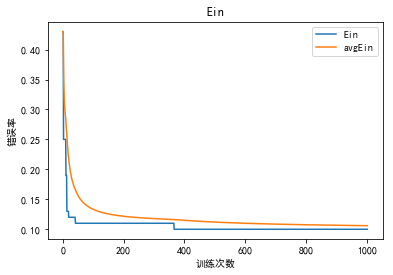

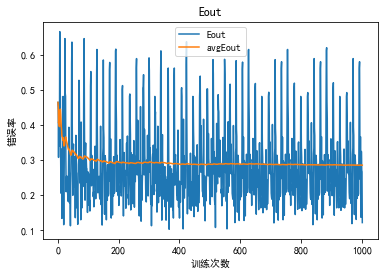

In [67]:
#n为训练次数,k为步长
def show(n,k):
    #计算Ein,Eout
    Ein,Eout,W=PocketPLA(train,test,k,n)

    #计算平均值
    t=np.arange(1,n+1)
    avgEin=np.cumsum(Ein)/t
    avgEout=np.cumsum(Eout)/t
    
    #Ein作图
    plt.plot(t,Ein,label='Ein')
    plt.plot(t,avgEin,label='avgEin')
    plt.title('Ein')
    plt.xlabel('训练次数')
    plt.ylabel('错误率')
    plt.legend()
    plt.show()

    #Eout作图
    plt.plot(t,Eout,label='Eout')
    plt.plot(t,avgEout,label='avgEout')
    plt.title('Eout')
    plt.xlabel('训练次数')
    plt.ylabel('错误率')
    plt.legend()
    plt.show()
    
show(1000,1)

可以看到$E_{in}(w(t)),E_{in} (\hat w),E_{out} (\hat w) $随着训练次数增加逐渐减少，而$E_{out} (w(t))$随着训练次数增加则波动较大。

#### Exercise 3.3 (Page 87)

Consider the hat matrix $H = X(X^TX)^{-1}X^T$, where $X$ is an $N$ by $d+1$ matrix, and $X^TX$ is invertible. 

(a) Show that $H$ is symmetric. 

(b) Show that$ H^K = H$ for any positive integer $K$. 

(c) If $I$ is the identity matrix of size N, show that $(I - H)^K = I - H$ for any positive integer K. 

(d) Show that $trace(H) = d +1$, where the trace is the sum of diagonal elements. [Hint: $trace(AB) = trace(BA)$]

(a)证明$H$是对称矩阵
$$
\begin{aligned}
H^T&=(X(X^TX)^{-1}X^T)^T
\\&=X((X^TX)^{-1})^TX^T
\\&=X((X^TX)^T)^{-1}X^T
\\&=X(X^TX)^{-1}X^T
\\&=H
\end{aligned}
$$
(b)证明$ H^K = H$ ,直接验证即可，先来看$K=2$的情形
$$
\begin{aligned}
H^2&=X(X^TX)^{-1}X^TX(X^TX)^{-1}X^T
\\&=X(X^TX)^{-1}X^T
\\&=H
\end{aligned}
$$
那么对于任意$K$
$$
\begin{aligned}
H^K&=H^2H^{K-2}
\\&=HH^{K-2}
\\&=H^{K-1}
\\&=...
\\&=H
\end{aligned}
$$
(c)利用二项式定理直接打开验证
$$
\begin{aligned}
(I-H)^K&=\sum_{i=0}^{i=K}C_K^iI^{K-i}(-H)^{i}
\\&=\sum_{i=0}^{i=K}C_K^i(-1)^iH^i
\\&=I+H\sum_{i=1}^{i=K}C_K^i(-1)^i(注意H^i=H)
\\&=I+H[(1-1)^K-1]
\\&=I-H
\end{aligned}
$$
(d)利用迹(trace)的性质$trace(AB) = trace(BA)$
$$
\begin{aligned}
trace(H)&=trace(X(X^TX)^{-1}X^T)
\\&=trace(X^TX(X^TX)^{-1})
\\&=trace(I_{d+1})(注意H^TH为(d+1)\times (d+1)阶矩阵)
\\&=d+1
\end{aligned}
$$


#### Exercise 3.4 (Page 88)

Consider a noisy target $y = w^{*T}x + \epsilon$ for generating the data, where $\epsilon$ is a noise term with zero mean and $\sigma^2$ variance, independently generated for every example $(x, y) $. The expected error of the best possible linear fit to this target is thus  $\sigma^2$ . 

For the data $\mathcal{D} = \{(x_1 , y_1 ), . . . , (x_N , y_N)\}$, denote the noise in $yn$ as $\epsilon_n$ and let $\epsilon=[\epsilon_1,\epsilon_2,...,\epsilon_N]^T$; assume that $X^TX$ is invertible. By fllowing the steps below, show that the expected in sample error of linear regression with respect to $\mathcal D$ is given by . 
$$
E_{\mathcal D}[E_{in}(w_{lin})] = \sigma^2(1-\frac{d+1}N)
$$
(a) Show that the in sample estimate of is given by $\hat y= Xw^* + H\epsilon.$ 

(b) Show that the in sample error vector $\hat y-y$ can be expressed by a matrix times $\epsilon$. What is the matrix? 

(c) Express $E_{in}(w_{lin})$ in terms of $\epsilon$ using (b ), and simplify the expression using Exercise 3.3(c). 

(d) Prove that $E_{\mathcal D}[E_{in}(w_{lin})] = \sigma^2(1-\frac{d+1}N)$ using (c) and the independence of $\epsilon_1,\epsilon_2,...,\epsilon_N$ . [Hint: The sum of the diagonal elements of a matrix (the trace) wil play a role. See Exercise 3.3]

For the expected out of sample error, we take a special case which is easy to analyze. Consider a test data set $\mathcal D_{test}=\{(x_1 , {y^{'}_1} ), . . . , (x_N , {y^{'}_N})\}$ which shares the same input vectors $x_n$ with $\mathcal D$ but with a different realization of the noise terms. Denote the noise in $y^{'}_n$ as $\epsilon^{'}_n$and let $\epsilon^{'}=[\epsilon^{'}_1,\epsilon^{'}_2,...,\epsilon^{'}_N]^T$. Define Etest(W!in) to be the average squared error on $\mathcal D_{test}$.

(e) Prove that $E_{\mathcal D,\epsilon^{'}}[E_{in}(w_{lin})] = \sigma^2(1+\frac{d+1}N) $. 

The special test error $E_{test}$ is a very restricted case of the general out-of sample error. Some detailed analysis shows that similar results can be obtained for the general case, as shown in Problem 3.1.    

(a)首先将$y = w^{*T}x + \epsilon$改写为向量的形式，记$y=[y_1...y_N]^T,X=[x_1...x_N]^T$，注意题目中给出$\epsilon=[\epsilon_1,\epsilon_2,...,\epsilon_N]^T$

那么
$$
y=Xw^*+\epsilon
$$


我们知道$w_{lin}=(X^TX)^{-1}X^Ty$

那么
$$
\begin{aligned}
\hat y&=Xw_{lin}
\\&=X(X^TX)^{-1}X^Ty
\\&=X(X^TX)^{-1}X^T(Xw^* + \epsilon)
\\&=X(X^TX)^{-1}X^TXw^*+X(X^TX)^{-1}X^T\epsilon
\\&=Xw^*+H\epsilon
\end{aligned}
$$
其中$H=X(X^TX)^{-1}X^T$的定义来自于Exercise 3.3

(b)直接计算即可
$$
\begin{aligned}
\hat y-y&=Xw^*+H\epsilon-(Xw^*+\epsilon)
\\&=(H-I)\epsilon
\end{aligned}
$$
(c)直接计算即可，注意要用到Exercise 3.3证明的性质
$$
\begin{aligned}
E_{in}(w_{lin})&=\frac 1N||\hat y-y||^2
\\&=\frac 1N||(H-I)\epsilon||^2
\\&=\frac 1N((H-I)\epsilon)^T((H-I)\epsilon)
\\&=\frac 1N \epsilon^T(H-I)(H-I)\epsilon(注意H对称)
\\&=\frac 1N \epsilon^T(I-H)\epsilon(注意(I - H)^K = I - H)
\\&=\frac 1N \epsilon^T(I-H)\epsilon
\end{aligned}
$$
(d)这题也是直接计算，注意要用到trace的性质和上题结论
$$
\begin{aligned}
E_{\mathcal D}[E_{in}(w_{lin})]&=\frac 1N E_{\mathcal D}( \epsilon^T(I-H)\epsilon)
\\&=\frac 1N E_{\mathcal D}trace( \epsilon^T(I-H)\epsilon)(这一步是由于\epsilon^T(I-H)\epsilon是一个实数，对于实数a,a=trace(a))
\\&=\frac 1N E_{\mathcal D}trace( \epsilon^T\epsilon-\epsilon^TH\epsilon))
\\&=\frac 1N [E_{\mathcal D}(\sum_{i=1}^N\epsilon_i^2)-E_{\mathcal D}(\sum_{i=1}^N\epsilon_iH_{ii}\epsilon_i)](H_{ii}为H第(i,i)个元素)
\\&=\frac 1N [N\sigma^2-(\sum_{i=1}^NH_{ii})\sigma^2]
\\&=\frac 1N [N\sigma^2-trace(H)\sigma^2](注意上一题结论trace(H)=d+1)
\\&=\frac 1N [N\sigma^2-(d+1)\sigma^2]
\\&=\sigma^2(1-\frac{d+1}N)
\end{aligned}
$$
为了方便解决下一题，我们把上述计算中的两个结果单独列出
$$
E_{\mathcal D}(\epsilon^T\epsilon)=N\sigma^2
\\E_{\mathcal D}(\epsilon^TH\epsilon))=(d+1)\sigma^2
$$
(e)首先还是改写为向量的形式$y^{'}=[y^{'}_1...y^{'}_N]^T,X=[x_1...x_N]^T,\epsilon^{'}=[\epsilon^{'}_1,\epsilon^{'}_2,...,\epsilon^{'}_N]^T$，那么
$$
y^{'}=Xw^*+\epsilon^{'}
$$
那么由(a)的结论知
$$
\hat y=Xw_{lin}=Xw^*+H\epsilon
$$
因此
$$
\begin{aligned}
E_{test}(w_{lin})&=\frac 1N||\hat y-y^{'}||^2
\\&=\frac 1N||Xw^*+H\epsilon-(Xw^*+\epsilon^{'})||^2
\\&=\frac 1N||H\epsilon-\epsilon^{'}||^2
\\&=\frac 1N(H\epsilon-\epsilon^{'})^T(H\epsilon-\epsilon^{'})
\\&=\frac 1N(\epsilon^TH-\epsilon^{'T})(H\epsilon-\epsilon^{'})(注意H对称)
\\&=\frac 1N(\epsilon^THH\epsilon-2\epsilon^{'T}H\epsilon+\epsilon^{'T}\epsilon^{'})
\\&=\frac 1N(\epsilon^TH\epsilon-2\epsilon^{'T}H\epsilon+\epsilon^{'T}\epsilon^{'})(注意H^K=H)
\end{aligned}
$$
接着我们计算$E_{\mathcal D,\epsilon^{'}}[E_{in}(w_{lin})]$
$$
\begin{aligned}
E_{\mathcal D,\epsilon^{'}}[E_{in}(w_{lin})]&=E_{\mathcal D,\epsilon^{'}}[\frac 1N(\epsilon^TH\epsilon-2\epsilon^{'T}H\epsilon+\epsilon^{'T}\epsilon^{'})]
\\&=\frac 1N[E_{\mathcal D,\epsilon^{'}}(\epsilon^TH\epsilon)-2E_{\mathcal D,\epsilon^{'}}(\epsilon^{'T}H\epsilon)+E_{\mathcal D,\epsilon^{'}}(\epsilon^{'T}\epsilon^{'})]
\end{aligned}
$$
回顾上一题单独列出的结论
$$
E_{\mathcal D}(\epsilon^T\epsilon)=N\sigma^2
\\E_{\mathcal D}(\epsilon^TH\epsilon))=(d+1)\sigma^2
$$
因此
$$
E_{\mathcal D,\epsilon^{'}}[E_{in}(w_{lin})]=\sigma^2(1+\frac{d+1}N)-\frac 2NE_{\mathcal D,\epsilon^{'}}(\epsilon^{'T}H\epsilon)
$$
后面我们单独计算$E_{\mathcal D,\epsilon^{'}}(\epsilon^{'T}H\epsilon)$，注意$\epsilon_i,\epsilon_i^{'}$独立且$E(\epsilon_i)=E(\epsilon_i^{'})=0$
$$
\begin{aligned}
E_{\mathcal D,\epsilon^{'}}(\epsilon^{'T}H\epsilon)&=E_{\mathcal D,\epsilon^{'}}(trace(\epsilon^{'T}H\epsilon))
\\&=E_{\mathcal D,\epsilon^{'}}(\sum_{i=1}^N\epsilon_i^{'}H_{ii}\epsilon_i)
\\&=\sum_{i=1}^N(E(\epsilon_i^{'})H_{ii}E(\epsilon_i))(由独立性)
\\&=0(数学期望为0)
\end{aligned}
$$
因此
$$
E_{\mathcal D,\epsilon^{'}}[E_{in}(w_{lin})]=\sigma^2(1+\frac{d+1}N)
$$


#### Exercise 3.5 (Page 90)

Another popular soft threshold is the hyperbolic tangent 
$$
tanh(s) = \frac{e^s -e^{-s}}{e^s +e^{-s}}
$$
(a) How is $tanh$ related to the logistic function $\theta$? [Hint: shift and scale] 

(b) Show that $tanh(s)$ converges to a hard threshold for large $|s|$, and converges to no threshold for small $|s|$ [Hint: Formalize the figure below.]    

![](https://github.com/Doraemonzzz/Learning-from-data/blob/master/photo/Chapter3/Exercise3.5.png?raw=true)

(a)我们先回顾$\theta$的定义
$$
\theta(s)=\frac{e^s}{1+e^s}
$$
那么
$$
\begin{aligned}
tanh(s) &= \frac{e^s -e^{-s}}{e^s +e^{-s}}
\\&=\frac{e^{2s}-1}{e^{2s}+1}
\\&=\frac{2e^{2s}-(1+e^{2s})}{e^{2s}+1}
\\&=2\frac{e^{2s}}{1+e^{2s}}-1
\\&=2\theta(2s)-1
\end{aligned}
$$
所以$tanh(s)$相当于$\theta(s)$先沿x轴方向压缩一倍，再y轴方向扩张1倍，最右沿y轴向下平移一个单位

(b)这题我不是很理解题目中所说的converges to no threshold for small $|s|$ ，我看了下论坛上老师的回复以及参考图片，猜测是threshold是水平渐近线的意思，所以我们计算$\frac {tanh(s)}{s}$，这里使用了$Taylor$展开。
$$
\begin{aligned}
\\limit_{s\to\infty}\frac{tanh(s)}s&=limit_{s\to\infty}\frac{1-e^{-2s}}{(1+e^{-2s})s}
\\&=limit_{s\to\infty}\frac{1-(1-2s)}{(1+1-2s)s}
\\&=0
\end{aligned}
$$

$$
\begin{aligned}
\\limit_{s\to0}\frac{tanh(s)}s&=limit_{s\to0}\frac{1+s-(1-s)}{(1+s+(1-s))s}
\\&=limit_{s\to0}\frac{2}{2}
\\&=1
\end{aligned}
$$
所以当$|s|\to \infty$，$tanh(s)$有水平渐近线,$|s|\to 0$，$tanh(s)$没有水平渐近线

#### Exercise 3.6 (Page 92)

[Cross-entropy error measure] 

(a) More generally, if we are learning from $±1$ data to predict a noisy target $P(y |x)$ with candidate hypothesis $h$, show that the maximum likelihood method reduces to the task of finding $h$ that minimizes 
$$
E_{in}(w)=\sum_{n=1}^N[\![y_n=+1]\!]ln\frac{1}{h(x_n)}+[\![y_n=-1]\!]ln\frac{1}{1-h(x_n)}
$$
(b) For the case $h(x) = \theta(w^Tx)$, argue that minimizing the in sample error in part (a) is equivalent to minimizing the one in (3.9) . 

For two probability distributions ${p, 1 - p}$ and ${q, 1-q}$ with binary outcomes, the cross entropy (from information theory) is 
$$
plog{\frac 1 q}+(1-p)log{\frac 1 {1-q}}
$$
The in sample error in part (a) corresponds to a cross entropy error measure on the data point $(x_n , y_n) $, with $p = [\![y_n = +1]\!]$ and $q = h(x_n).$    

(a)记最大似然函数为$L$
$$
L=\prod_{i=1}^N(h(x_n))^{[\![y_n=+1]\!]}(1-h(x_n))^{[\![y_n=-1]\!]}
\\lnL=e^{\sum_{n=1}^N[\![y_n=+1]\!]ln{h(x_n)}+[\![y_n=-1]\!]ln{(1-h(x_n))}}
$$
因此要使得$L$最大，只要使$\sum_{n=1}^N[\![y_n=+1]\!]ln{h(x_n)}+[\![y_n=-1]\!]ln{(1-h(x_n))}$最大即可，也就是使得$-(\sum_{n=1}^N[\![y_n=+1]\!]ln{h(x_n)}+[\![y_n=-1]\!]ln{(1-h(x_n))})$最小，注意以下事实
$$
-(\sum_{n=1}^N[\![y_n=+1]\!]ln{h(x_n)}+[\![y_n=-1]\!]ln{(1-h(x_n))})=\sum_{n=1}^N[\![y_n=+1]\!]ln\frac{1}{h(x_n)}+[\![y_n=-1]\!]ln\frac{1}{1-h(x_n)}=E_{in}(w)
$$
因此结论成立。

(b)回顾下3.9
$$
E^{'}_{in}(w)=\frac 1N\sum_{n=1}^Nln(1+e^{-y_nw^Tx_n})
$$
注意$\theta(s)=\frac{e^s}{1+e^s}$，那么
$$
\theta(-s)=\frac{e^{-s}}{1+e^{-s}}=\frac{1}{1+e^{s}}=1-\theta(s)
\\h(x) = \theta(w^Tx)= \frac{e^{w^Tx}}{1+e^{w^Tx}}
\\h(-x) = \theta(w^T(-x))= 1-\theta(w^Tx)=1-h(x)
$$
我们对这里的$E_{in}(w)$进行一个处理
$$
[\![y_n=+1]\!]ln\frac{1}{h(x_n)}=[\![y_n=+1]\!]ln\frac{1}{h(y_nx_n)}
\\ [\![y_n=-1]\!]ln\frac{1}{1-h(x_n)}=[\![y_n=-1]\!]ln\frac{1}{h(-x_n)}=[\![y_n=-1]\!]ln\frac{1}{h(y_nx_n)}
$$
代入我们这里的$E_{in}(w)$
$$
\begin{aligned}
E_{in}(w)&=\sum_{n=1}^N[\![y_n=+1]\!]ln\frac{1}{h(x_n)}+[\![y_n=-1]\!]ln\frac{1}{1-h(x_n)}
\\&=\sum_{n=1}^N([\![y_n=+1]\!]+[\![y_n=-1]\!])ln\frac{1}{h(y_nx_n)}
\\&=\sum_{n=1}^Nln\frac{1}{h(y_nx_n)}
\\&=\sum_{n=1}^Nln(\frac{e^{y_nw^Tx}}{1+e^{y_nw^Tx}})^{-1}
\\&=\sum_{n=1}^Nln(1+e^{-y_nw^Tx_n})
\\&=NE^{'}_{in}(w)
\end{aligned}
$$
因此最小化$E_{in}(w)$等价于最小化$E^{'}_{in}(w)$

题目最后的意思是这里的结论可以和信息论里的结论类比。

#### Exercise 3.7 (Page 92)

For logistic regression , show that \Ein(w) 
$$
\begin{aligned}
\nabla E_{in}(w)
&=-\frac 1N \sum_{n=1}^N\frac{y_nx_n}{1+e^{y_nw^Tx_n}}
\\&=\frac 1N \sum_{n=1}^N-{y_nx_n}\theta(-y_nw^Tx_n)
\end{aligned}
$$
Argue that a 'misclassified' example contributes more to the gradient than a correctly classified one.  

这题就是对logistic的$ E_{in}(w)$求梯度，回顾下$E_{in}(w)$
$$
E_{in}(w)=\frac 1N\sum_{n=1}^Nln(1+e^{-y_nw^Tx_n})
$$
注意$\theta(s)=\frac{e^s}{1+e^s}$
$$
\begin{aligned}
\frac{\partial E_{in}(w)}{\partial{w_i}}
&=\frac 1N\sum_{n=1}^N\frac{ln(1+e^{-y_nw^Tx_n})}{\partial{w_i}}
\\&=\frac 1N\sum_{n=1}^N \frac{1}{1+e^{-y_nw^Tx_n}}\frac{\partial e^{-y_nw^Tx_n}}{\partial{w_i}}
\\&=\frac 1N\sum_{n=1}^N \frac{1}{1+e^{-y_nw^Tx_n}}(- e^{-y_nw^Tx_n})(y_nx_n^{(i)})(x_n^{(i)}表示x_n的第i个分量)
\\&=\frac 1N\sum_{n=1}^N -y_nx_n^{(i)}\frac{e^{-y_nw^Tx_n}}{1+e^{-y_nw^Tx_n}}
\\&=\frac 1N\sum_{n=1}^N -y_nx_n^{(i)}\frac{1}{1+e^{y_nw^Tx_n}}
\\&=\frac 1N\sum_{n=1}^N-y_nx_n^{(i)}\theta(-y_nw^Tx_n)
\end{aligned}
$$
因此
$$
\begin{aligned}
\nabla E_{in}(w)
&=-\frac 1N \sum_{n=1}^N\frac{y_nx_n}{1+e^{y_nw^Tx_n}}
\\&=\frac 1N \sum_{n=1}^N-{y_nx_n}\theta(-y_nw^Tx_n)
\end{aligned}
$$
当一个样例错分时，$y_nw^Tx_n<0$，对应的$\theta(-y_nw^Tx_n)>\frac12$；当一个样例分类正确时，$y_nw^Tx_n>0$对应的$\theta(-y_nw^Tx_n)<\frac12$，因此错分的样例的权重比正确的样例要大。

#### Exercise 3.8 (Page 94)

The claim that $\hat v$ is the direction which gives largest decrease in $E_{in}$only holds for small $\eta$. Why?    

回顾下书上之前的叙述
$$
\begin{aligned}
\Delta E_{in}&=E_{in}(w(0)+\eta \hat v)-E_{in}(w(0))
\\&=\eta \nabla E_{in}(w(0))^T \hat v+O(\eta^2)
\\&\ge \eta ||\nabla E_{in}(w(0))||
\\\hat v&=-\frac{\nabla E_{in}(w(0))}{||\nabla E_{in}(w(0))||}时等号成立
\end{aligned}
$$
这个式子是泰勒展开，所以$\eta \hat v$的模不能太大，如果太大，泰勒展开的偏差会很大。$\hat v$是单位向量，因此$||\eta \hat v||=\eta$，所以上述式子只有当$\eta$较小的时候才有效。

#### Exercise 3.9 (Page 97)

Consider pointwise error measures $e_{class}(s,y)=[\![y\neq sign(s)]\!]$,$e_{sq}(s,y)=(y-s)^2$,and$ e_{log}(s,y)=ln(1+exp(-ys))$,where the signal $s=w^Tx$

(a) For $y = +1$, plot $e_{class},e_{sq}$ and $\frac 1{ln2}e_{log}$ versus $s$, on the same plot.

(b) Show that $e_{class}(s,y)\le e_{sq}(s,y)$, and hence that the classification
error is upper bounded by the squared error.

(c) Show that $e_{class}(s,y)\le\frac 1{ln2}e_{log}(s,y)$ ,and, as in part (b), get an
upper bound (up to a constant factor) using the logistic regression
error.
These bounds indicate that minimizing the squared or logistic regression
error should also decrease the classification error, which justifies using the
weights returned by linear or logistic regression as approximations for classification.

(a),(b),(c)三题作图即可

In [85]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

def Class(s,y):
    if s*y>0:
        return 0
    else:
        return 1
    
def Sq(s,y):
    return (s-y)**2

def Log(s,y):
    return np.log(1+np.exp(-y*s))

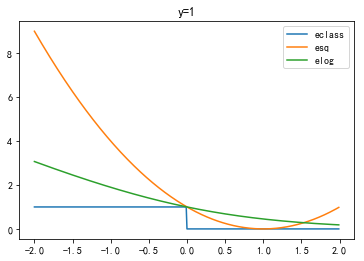

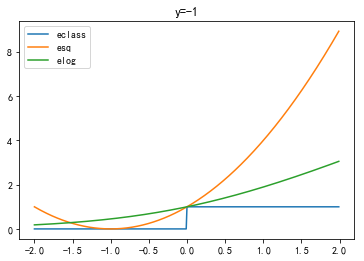

In [92]:
#构造点
x=np.arange(-2,2,0.01)

#y=1
eclass1=[Class(i,1) for i in x]
esq1=[Sq(i,1) for i in x]
elog1=[Log(i,1)/np.log(2) for i in x]

#y=-1
eclass2=[Class(i,-1) for i in x]
esq2=[Sq(i,-1) for i in x]
elog2=[Log(i,-1)/np.log(2) for i in x]

plt.plot(x,eclass1,label='eclass')
plt.plot(x,esq1,label='esq')
plt.plot(x,elog1,label='elog')
plt.title('y=1')
plt.legend()
plt.show()

plt.plot(x,eclass2,label='eclass')
plt.plot(x,esq2,label='esq')
plt.plot(x,elog2,label='elog')
plt.title('y=-1')
plt.legend()
plt.show()

从图像中我们看出， $e_{sq}$ 和 $\frac 1{ln2}e_{log}$ 都是$e_{class}$的上界，因此我们可以用线性回归或者logistic回归计算结果，再用产生的结果喂给PLA。

#### Exercise 3.10 (Page 98)

(a)Define an error for a single data point $(x_n, y_n)$ to be 
$$
e_n(w) = max(0, -y_nw^Tx_n)
$$
Argue that PLA can be viewed as SGD on $e_n$ with learning rate $\eta = 1$. 

(b) For logistic regression with a very large $w$, argue that minimizing $E_{in}$ using SGD is similar to PLA. This is another indication that the logistic regression weights can be used as a good approximation for classification .   

 (a)$e_n(w) = max(0, -y_nw^Tx_n)$的意思是对于分类正确的点$e_{in}(w)=0$，对于分类不正确的点$e_n(w)=-y_nw^Tx_n $，我们来求梯度
$$
\frac {\partial(-y_nw^Tx_n)}{\partial w_i}=-y_nx^{(i)}_n(x^{(i)}_n表示x_n的第i个分量)
\\\nabla(-y_nw^Tx_n)=-y_nx_n
$$
所以对于分类错误的点$(x_n,y_n)$，根据SGD,更新规则为
$$
w(t+1)=w(t)+\eta(-\nabla(-y_nw^Tx_n))=w(t)+\eta y_nx_n
$$
所以PLA可以被看成$e_n(w) = max(0, -y_nw^Tx_n)$的SGD且$\eta=1$的情形

(b)我们知道logistic的梯度公式有如下形式
$$
\nabla E_{in}(w)=-\frac 1N \sum_{n=1}^N\frac{y_nx_n}{1+e^{y_nw^Tx_n}}
$$
那么对于SGD梯度即为
$$
\nabla e_{in}(w)= \frac{-y_nx_n}{1+e^{y_nw^Tx_n}}
$$
带入更新规则$w\gets w-\eta \nabla e_{in}(w)$
$$
w(t+1)=w(t)+ \frac{\eta y_nx_n}{1+e^{y_nw^Tx_n}}
$$
我们注意更新的点一定是错误的，即$y_nw^Tx_n<0$，那么当$w$非常大时，$e^{y_nw^Tx_n}\approx0$

因此对于非常大的$w$，上述更新规则可以近似为
$$
w(t+1)=w(t)+ {\eta y_nx_n}
$$
和PLA一致，这也从另一个角度说明了logistic是分类问题的一个近似

#### Exercise 3.11 (Page 101)

Consider the feature transform $\phi$ in (3.12). What kind of boundary in $\mathcal{X}$ does a hyperplane $\hat w$ in $\mathcal{Z}$ correspond to in the following cases? 

Draw a picture that illustrates an example of each case. 

(a) $\hat w_1>0, \hat w_2< 0 $

(b) $\hat w_1>0, \hat w_2= 0 $

(c) $\hat w_1>0, \hat w_2> 0,\hat w_0<0 $

(d) $\hat w_1>0, \hat w_2> 0,\hat w_0>0 $  

回顾下3.12
$$
\phi(x)=(1,x_1^2,x_2^2)
$$
因此对应方程为
$$
\hat w_0+\hat w_1x_1^2+\hat w_2 x_2^2=0
$$
后面的叙述实际上是高中解析几何的知识。

(a)有三种可能，分别是$\hat w_0=0,\hat w_0>0,\hat w_0<0$

In [96]:
from sympy.parsing.sympy_parser import parse_expr  
from sympy import plot_implicit 
ezplot = lambda exper: plot_implicit(parse_expr(exper))

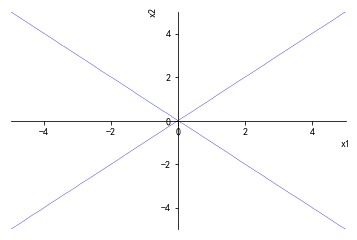

In [97]:
ezplot('x1**2-x2**2')

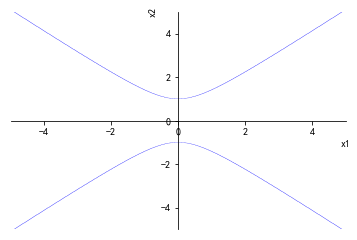

In [98]:
ezplot('1+x1**2-x2**2')

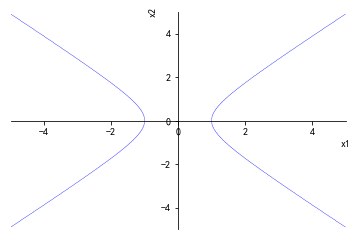

In [99]:
ezplot('-1+x1**2-x2**2')

(b)有三种可能，分别是$\hat w_0=0,\hat w_0>0,\hat w_0<0$

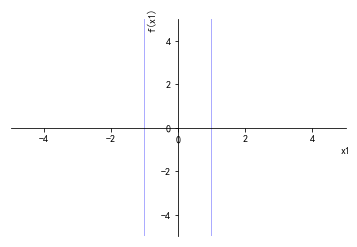

In [100]:
ezplot('-1+x1**2')

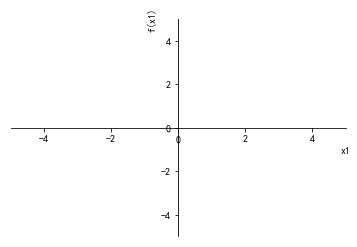

In [101]:
ezplot('0+x1**2')

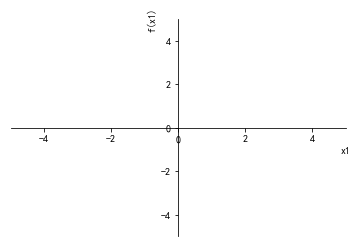

In [102]:
ezplot('1+x1**2')

(c)条件已经定死

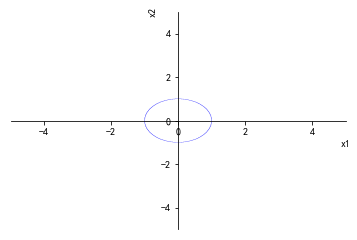

In [103]:
ezplot('-1+x1**2+x2**2')

(d)条件已经定死

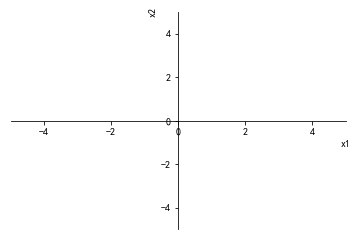

In [105]:
ezplot('1+x1**2+x2**2')

#### Exercise 3.12 (Page 103)

We know that in the Euclidean plane, the perceptron model $\mathcal{H}$ cannot implement all 16 dichotomies on 4 points. That is, $m_{\mathcal H}(4) < 16$. Tke the feature transform <in (3.12). 

(a) Show that $m_{\mathcal H \phi}(3) = 8$. 

(b) Show that $m_{\mathcal H \phi}(4) < 16$. 

(c) Show that $m_{\mathcal H \bigcup\mathcal H \phi}(4) = 16$. 

That is, if you used lines, $d_{vc} = 3$; if you used elipses, $d_{vc} = 3$; if you used lines and elipses, $d_{vc} > 3$.    

(a)作图即可，这里画图比较麻烦，略去了

(b)我们找三个特殊的点

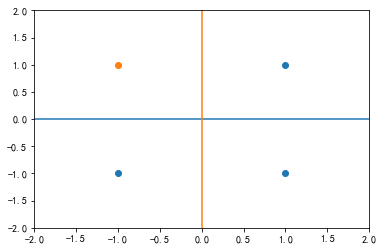

In [117]:
import matplotlib.pyplot as plt

x=[-1,1,1]
y=[-1,-1,1]
plt.scatter(x,y)
plt.scatter(-1,1)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.plot([-2,2],[0,0])
plt.plot([0,0],[-2,2])
plt.xticks()
plt.show()

我们用上一题给出的几种二次曲线图形去匹配，可以发现无法区分这种形式。

(c)这里只列一种我们我们之前感知机无法表示的情况

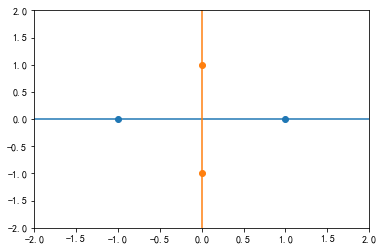

In [121]:
import matplotlib.pyplot as plt

plt.scatter([-1,1],[0,0])
plt.scatter([0,0],[-1,1])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.plot([-2,2],[0,0])
plt.plot([0,0],[-2,2])
plt.xticks()
plt.show()

这种形式可以用双曲线进行划分，其余的情形用直线可以轻松划分出来，这里不列出来了。

#### Exercse 3.13 (Page 104)

Consider the feature transform $z=\phi_2(x)$ in (3.13). How can we use a hyperplane $\hat w$ in $\mathcal Z$ to represent the following boundaries in $\mathcal X$

(a) parabola$ (x_1-3)^2+x_2 = 1$

(b) The circle $(x_1-3)^2+(x_2 - 4)^2 =1$

(c) The ellipse $2(x_1 - 3)^2+ (x_2-4)^2 = 1$

(d) The hyperbola $(x_1 - 3)^2-(x_2-4)^2=1 $

(e) The elipse $2(x_1+x_2-3)^2+(x_1 - x_2 - 4)^2 =1$

(f) line $2x_1+x_2 =1 $   

回顾3.13
$$
\phi_2(x)= (1, x_1 , x_2 , x_1^2 , x_1x_2 , x_2^2)
$$
接下来分别打开上述6个式子即可

(a)
$$
(x_1-3)^2+x_2 = 1
 \\ x_1^2-6x_1+9+x_2 -1=0
 \\8-6x_1+x_2+x_1^2=0
 \\\hat w=(8,-6,1,1,0,0)
$$
(b)
$$
(x_1-3)^2+(x_2 - 4)^2 =1
\\x_1^2-6x_1+x_2^2-8x_2+24=0
\\\hat w=(24,-6,-8,1,0,1)
$$
(c)
$$
2(x_1 - 3)^2+ (x_2-4)^2 = 1
\\2(x_1^2-6x_1+9)+(x_2^2-8x_2+16)-1=0
\\2x_1^2-12x_1+x_2^2-8x_2+33=0
\\\hat w=(33,-12,-8,2,0,1)
$$
(d)
$$
(x_1 - 3)^2-(x_2-4)^2=1
\\x_1^2-6x_1+9-(x_2^2-8x_2+16)-1=0
\\x_1^2-x_2^2+8x_2-6x_1-8=0
\\\hat w=(-8,-6,8,1,0,-1)
$$
(e)
$$
2(x_1+x_2-3)^2+(x_1 - x_2 - 4)^2 =1
\\2[(x_1+x_2)^2+9-6(x_1+x_2)]+(x_1-x_2)^2-8(x_1-x_2)+16-1=0
\\2(x_1^2+x_2^2+2x_1x_2+9-6x_1-6x_2)+x_1^2+x_2^2-2x_1x_2-8x_1+8x_2+15=0
\\3x_1^2+3x_2^2+33-20x_1-4x_2+2x_1x_2=0
\\ \hat w=(33,-20,-4,3,2,3)
$$
(f)
$$
2x_1+x_2 =1
\\2x_1+x_2 -1=0
\\ \hat w=(-1,2,1,0,0,0)
$$


#### Exercise 3.14 (Page 105)

Consider the $Q$th order polynomial transform $\phi_Q$ for $\mathcal{X}= R^d$. What is the dimensionality $\widetilde d$ of the feature space $\mathcal Z$ (excluding the fixed coordinate $z_0 = 1$). Evaluate your result on $d\in  \{2, 3, 5, 1\} $and $Q\in \{2, 3, 5, 1\}$.    

注意设$x=(x_1...x_d)$，那么多项式转换的一般形式为$\prod_{i=1}^d x_i^{n_i}$，那么$Q$次多项式相当于对此加了一个条件($z_0=1$不算在内)
$$
1\le\sum_{i=1}^{d}n_i\le Q(n_i\ge0)
$$
我们记$\sum_{i=1}^{d}n_i=q(n_i\ge0)$的解的数量为$f(q)$，那么$1\le\sum_{i=1}^{d}n_i\le Q(n_i\ge0)$的解的数量为
$$
\\\sum_{q=1}^Qf(q)
$$
我们接下来求解$f(q)$，对式子稍做变性
$$
\sum_{i=1}^{d}n_i=q(n_i\ge0)
\\ \sum_{i=1}^{d}(n_i+1)=q+d(n_i\ge0)
\\令n_i+1=m_i，那么上式可化为
\\ \sum_{i=1}^{d}(m_i)=q+d(m_i\ge1)
\\所以求正整数解即可，隔板法可得
\\f(q)=C_{q+d-1}^{d-1}
$$
因此
$$
\hat h=\sum_{q=1}^Qf(q)=\sum_{q=1}^QC_{q+d-1}^{d-1}
$$
我们将$d=2$带入
$$
\hat h=\sum_{q=1}^Qf(q)=\sum_{q=1}^QC_{q+1}^{1}=2+...(Q+1)=\frac{Q(Q+3)}{2}
$$
符合课本104页的叙述

#### Exercise 3.15 (Page 106)

High-dimensional feature transfrms are by no means the only transforms that we can use. We can take the tradeoff in the other direction, and use low dimensional feature transforms as well (to achieve an even lower generalization error bar).    Consider the following fature transform, which maps a $d$-dimensional $x$ to a one-dimensional $z$, keeping only the $k$th coordinate of x. 
$$
\phi_{(k)}(x)=(1,x_k)
$$
Let $\mathcal{H_k}$ be the set of perceptrons in the feature space. 

(a) Prove that $d_{vc}(\mathcal{H_k}) = 2$. 

(b) Prove that $d_{vc}(\bigcup_{k=1}^d\mathcal{H_k})\le 2(log_2 d +1)$. 

$\mathcal{H_k}$ is called the decision stump model on dimension $k$.    

(a)这个比较简单，$\mathcal{H_k}$是特征空间里的感知机，并且特征空间的维度为1，因此根据感知机的性质，我们知道$d_{vc}(\mathcal{H_k}) = 1+1=2$

(b)我们来看下$\mathcal{H_k}$的具体形式，设参数为$(w_0,w_1)$，那么对应的边界平面为
$$
w_0+w_1x_k=0
\\x_k=-\frac{w_0}{w_1}
$$
因此$\mathcal{H_k}$划分方法可以理解为看第$k$个下标，如果$x_k$大于阈值$-\frac{w_0}{w_1}$，标记为1，反之标记为-1，或者反过来(大于$-\frac{w_0}{w_1}$标记为-1,小于$-\frac{w_0}{w_1}$标记为1)。

假设现在有$N$个点，现在来计算$\mathcal H_{ k}$能区分的数量，先对这$N$个点的第$k$个坐标排序，**先不管全1或者全-1的两种情况**，那么$\mathcal H_{ k}$相当于在这$N$个$x_k$的$N-1$个间隔挑选，一共可以有$N-1$种选择，那么由于大于阈值可以为1，也可以为-1，所以一共可以区分$2(N-1)$种情形，因此
$$
出去全1或者全-1的情况，每个\mathcal{H_k}可以区分2N-2种情形
$$
那么$\bigcup_{k=1}^d\mathcal{H_k}$一共可以表示$f(N)=2(N-1)\times d+2$种情形，注意我们这里为了更加准确，全1或者全-1的情形合并在一起统计了。当$N=2(log_2 d +1)$时
$$
\begin{aligned}
f(N)&=2(N-1)\times d+2
\\&=2(2log_2d+1)\times d+2
\end{aligned}
$$
我们来证明
$$
f(N)=2(2log_2d+1)\times d+2\le 2^N=2^{2(log_2 d +1)}=4d^2
$$
接着我们来进行一些处理
$$
2(2log_2d+1)\times d+2\le4d^2\Leftrightarrow
\\ 2d(2log_2d+1)\le4d^2-2\Leftrightarrow
\\2log_2d+1\le2d-\frac 1d\Leftrightarrow
\\2d-\frac 1d-2log_2d-1\ge0
$$
记$g(d)=2d-\frac 1d-2log_2d-$1，求导得
$$
g^{'}(d)=2+\frac 1{d^2}-\frac {2ln2}{d}
\\g^{'}(d)>2-\frac {2ln2}{1}>0
$$
所以$g(d)$在$[1,+\infty)$递增递增，$g(d)\ge g(1)=0$

因此
$$
f(N)\le2^N(N=2(log_2 d +1))
$$
从而可得
$$
d_{vc}(\bigcup_{k=1}^d\mathcal{H_k})\le 2(log_2 d +1)
$$
这是因为在$N=2(log_2 d +1)$表示的种类数量小于等于$2^N$，所以最多shatter $2(log_2 d +1)$个点。



#### Exercise 3.16 (Page 106)

Write down the steps of the algorithm that combines $\phi_3$ with linear regression. How about using $\phi_{10}$ instead? Where is the main computational bottleneck of the resulting algorithm?    

这部分可以参考课本86页。我们直接对$\phi_k$进行总结,记特征空间的维度为$\widetilde d$，原始数据为$(x_1...x_N),(y_1...y_N)$。

第一步进行特征转换，记得到的新的数据为$(\widetilde x_1...\widetilde x_N)$，构成的矩阵为$\widetilde X$

第二步计算$(\widetilde X^T\widetilde X)^{-1}\widetilde X^T$

第三步计算$(\widetilde X^T\widetilde X)^{-1}\widetilde X^Ty$

主要计算时间应该是第二部求逆矩阵。

### Part 2:Problems

#### Problem 3.1 (Page 109)

Consider the double semi-circle "toy" learning task below.    

![](https://github.com/Doraemonzzz/Learning-from-data/blob/master/photo/Chapter3/Problem3.1.png?raw=true)

There are two semi circles of width $thk$ with inner radius $rad$, separated by sep as shown (red is -1 and blue is +1). The center of the top semi circle is aligned with the middle of the edge of the bottom semi circle. This task is linearly separable when $sep\ge0$, and not so for $sep<0$. Set $rad = 10, thk = 5$ and $sep = 5$. Then, generate 2,000 examples unifrmly, which means you will have approximately 1, 000 examples for each class. 

(a) Run the PLA starting from $w = 0$ until it converges. Plot the data and the final hypothesis. 

(b) Repeat part (a) using the linear regression (for classification) to obtain $w$. Explain your observations.    

这题看了非常久，楞是不明白什么意思，后来看了论坛里老师的回复才明白。题目的意思是有如图两个圆环，我们要在圆环内的区域随机生成点，然后用PLA和线性回归进行分类。我们先生成数据，这里我们将上半个圆环对应的圆心放在(a,b)，那么下半个圆环对应的圆心为$(a+rad+\frac {thk}{2},b-sep)$。为方便叙述，这里记录上半个圆环的圆心为$(X_1,Y_2)$，下半个圆环的圆心为$(X_2,Y_2)$。

接着介绍生成点的方式，我们在$[-rad-thk,rad+thk]\times[-rad-thk,rad+thk]$随机生成点，如果这个点$(x,y)$落在$rad^2\le x^2+y^2\le(rad+thk)^2$范围内，那么当$y>0$时，我们把这个点给上半个圆环，产生点**$(X_1+x,Y_1+y)$**，当$y<0$时，我们把这个点给下半个圆环，产生点$(X_2+x,Y_2+y)$；如果产生的点不在$rad^2\le x^2+y^2\le(rad+thk)^2$范围内，则重新产生点即可。这里产生点的方法有点类似参数方程的思路，**即产生相对于圆心的相对位置**，下面编程实现一下。

In [12]:
import numpy as np

#参数
rad=10
thk=5
sep=5

#n为产生点的个数,x1,y1为上半个圆环的坐标
def generatedata(rad,thk,sep,n,x1=0,y1=0):
    #上半个圆的圆心
    X1=x1
    Y1=y1

    #下半个圆的圆心
    X2=X1+rad+thk/2
    Y2=Y1-sep
    
    #上半个圆环的点
    top=[]
    #下半个圆环的点
    bottom=[]
    
    #后面要用到的参数
    r1=rad+thk
    r2=rad
    
    cnt=1
    while(cnt<=n):
        #产生均匀分布的点
        x=np.random.uniform(-r1,r1)
        y=np.random.uniform(-r1,r1)
        
        d=x**2+y**2
        if(d>=r2**2 and d<=r1**2):
            if (y>0):
                top.append([X1+x,Y1+y])
                cnt+=1
            else:
                bottom.append([X2+x,Y2+y])
                cnt+=1
        else:
            continue

    return top,bottom

接着作图看下

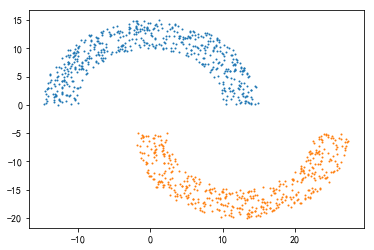

In [14]:
import matplotlib.pyplot as plt
top,bottom=generatedata(rad,thk,sep,1000)

X1=[i[0] for i in top]
Y1=[i[1] for i in top]

X2=[i[0] for i in bottom]
Y2=[i[1] for i in bottom]

plt.scatter(X1,Y1,s=1)
plt.scatter(X2,Y2,s=1)
plt.show()

可以看到和圆环形状还是很接近的，接着我们处理(a)

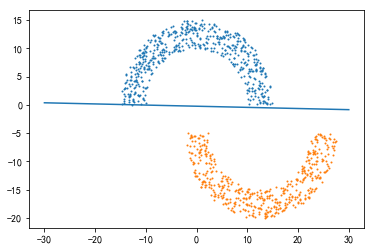

In [15]:
#对数据预处理，加上标签和偏移项1
x1=[[1]+i+[1] for i in top]
x2=[[1]+i+[-1] for i in bottom]
data=x1+x2
    
data=np.array(data)
np.random.shuffle(data)

#PLA
#定义sign函数
def sign(x):
    if x>0:
        return 1
    else:
        return -1

#定义判别函数，判断所有数据是否分类完成
def Judge(x,w):
    #n为数据维度
    n=x.shape[1]-1
    flag=1
    for i in x:
        if sign(i[:n].dot(w))*i[-1]<0:
            flag=0
            break
    return flag

#定义PLA,k为步长
def PLA(x,k):
    #n为数据维度,m为数据数量,
    m,n=x.shape
    n-=1
    #初始化向量
    w=np.zeros(n)
    #记录最后一个更新的向量
    last=0
    #记录次数
    t=0
    if Judge(x,w):
        pass
    else:
        #记录取哪个元素
        j=0
        while Judge(x,w)==0:
            i=x[j]
            #print(i[:n],i[-1])
            if sign(i[:n].dot(w))*i[-1]<0:
                w+=k*i[-1]*i[:n]
                t+=1
                last=j
            j+=1
            if(j>=m):
                j=j%m
    return t,last,w
t,last,w=PLA(data,1)

#作图
r=2*(rad+thk)
X3=[-r,r]
Y3=[-(w[0]+w[1]*i)/w[2] for i in X3]

plt.scatter(X1,Y1,s=1)
plt.scatter(X2,Y2,s=1)
plt.plot(X3,Y3)
plt.show()

(b)依旧要对数据作预处理，然后直接带入线性回归的公式即可

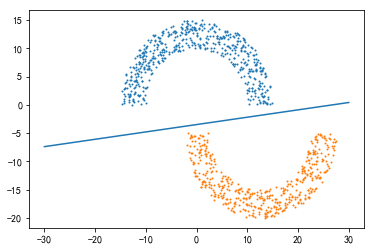

In [16]:
from numpy.linalg import inv

#对数据预处理
x1=[[1]+i for i in top]
y1=[1]*len(top)

x2=[[1]+i for i in bottom]
y2=[-1]*len(bottom)

X=np.array(x1+x2)
Y=np.array(y1+y2)

w1=inv(X.T.dot(X)).dot(X.T).dot(Y)

#作图
t=2*(rad+thk)
X4=[-t,t]
Y4=[-(w1[0]+w1[1]*i)/w1[2] for i in X4]


plt.scatter(X1,Y1,s=1)
plt.scatter(X2,Y2,s=1)
plt.plot(X4,Y4)
plt.show()

可以看到，线性回归同样能解决这个分类问题，和课本里的描述一致，相比PLA，线性回归得到的直线距离点集的间距更大。

#### Problem 3.2 (Page 109)

For the double semi circle task in Problem 3.1, vary $sep$ in the range $\{0.2, 0.4, . . . , 5\}$. Generate 2,000 examples and run the PLA starting with $w = 0$. Record the number of iterations PLA takes to converge. 

Plot $sep$ versus the number of iterations taken for PLA to converge. Explain your observations. [Hint: Problem 1.3.] 

和上题一致，不过这里改变了$sep$，我们要观察$sep$和迭代次数的关系，注意这里我们更换下上半个圆环的圆心

In [17]:
import numpy as np
#参数
rad=10
thk=5
sep=np.arange(0.2,5.2,0.2)

T=np.array([])

for k in sep:
    top,bottom=generatedata(rad,thk,k,2000,5,10)
    x1=[[1]+i+[1] for i in top]
    x2=[[1]+i+[-1] for i in bottom]
    data=x1+x2

    data=np.array(data)
    np.random.shuffle(data)
    
    #维度
    n=len(data[0])-1
    #数据组数
    m=len(data)
    
    t,last,w=PLA(data,1)
    
    T=np.append(T,t)

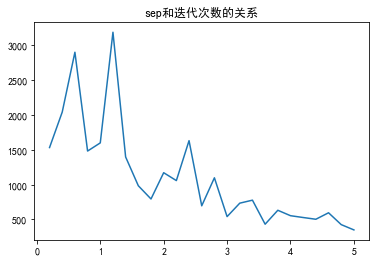

In [18]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

plt.plot(sep,T)
plt.title('sep和迭代次数的关系')
plt.show()

可以看到$sep$越大，迭代次数总体来说在下降。现在来简单分析下原因，回顾Problem 1.3(Page 33)
$$
\rho = {min}_{1\le n\le N} y_n(w^{*T} x_n )
\\ R = {max}_{1\le n\le N} ||xn ||
\\t\le \frac {R^2||w^*||^2} {\rho^2}
$$
这里圆环的位置固定，所以可以认为$R$是一个常数，我们来分析$\frac {||w^*||} {\rho}$。

由解析几何知识，我们知道$\frac {||w^{T} x_n||}{||w^{}||}$为$x_n$到平面$w^{T}x=0$的距离，而题目中的$\frac {||w^*||} {\rho}$相当于点集到平面$w^{*T}x=0$的最小距离的倒数，因此如果$sep$越大，最小距离也越大，从而$\frac {||w^*||} {\rho}$越小，迭代次数相应也会减少

#### Problem 3.3 (Page 109)

For the double semi circle task in Problem 3.1, set $sep = -5$ and generate 2, 000 examples. 

(a) What will happen if you run PLA on those examples? 

(b) Run the pocket algorithm for 100,000 iterations and plot $E_{in}$ versus the iteration number t. 

(c) Plot the data and the final hypothesis in part (b).    

(d) Use the linear regression algorithm to obtain the weights w, and compare this result with the pocket algorithm in terms of computation time and quality of the solution . 

(e) Repeat (b) - (d) with a 3rd order polynomial fatu re transform.       


这题的$sep<0$，所以数据不可分

(a)如果运行PLA，那么算法不会停下来

(b)回顾下Pocket PLA

![](https://github.com/Doraemonzzz/Learning-from-data/blob/master/photo/Chapter3/Problem3.3.png?raw=true)

编程实现，题目要求迭代十万次，我发现十万次实在是太慢了，所以改为10000次，先作图看一下

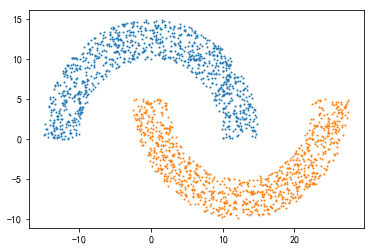

In [19]:
#参数
rad=10
thk=5
sep=-5

#产生数据
top,bottom=generatedata(rad,thk,sep,2000)

#作图
X1=[i[0] for i in top]
Y1=[i[1] for i in top]

X2=[i[0] for i in bottom]
Y2=[i[1] for i in bottom]

plt.scatter(X1,Y1,s=1)
plt.scatter(X2,Y2,s=1)
plt.show()

接着编写Pocket PLA

In [20]:
#Pocket PLA
#定义sign函数
def sign(x):
    if x>0:
        return 1
    else:
        return -1

#定义计算错误个数的函数
def CountError(x,w):
    #数据维度
    n=x.shape[1]-1
    #记录错误次数
    count=0
    for i in x:
        if sign(i[:n].dot(w))*i[-1]<0:
            count+=1
    return count


#定义PocketPLA,k为步长,max为最大更新次数
def PocketPLA(x,k,maxnum):
    #n为数据维度,m为数据数量
    m,n=x.shape
    #注意多了一个标志位
    n-=1
    #初始化向量
    w=np.zeros(n)
    #错误率最小的向量
    w0=np.zeros(n)
    error=CountError(x,w)
    #记录每次的错误
    Error=[]
    if error==0:
        pass
    else:
        #记录次数
        j=0
        while (j<maxnum or error==0):
            #随机选取数据
            k=np.random.randint(0,m)
            i=x[k]
            #得到w(t+1)
            w=w0+k*i[-1]*i[:n]
            error1=CountError(x,w)
            Error.append(error1)
            #如果w(t+1)比w(t)效果好，则更新w(t)
            if error>error1:
                w0=w[:]
                error=error1
            j+=1
    return w0,Error

带入算法

In [21]:
#对数据预处理，加上标签和偏移项1
x1=[[1]+i+[1] for i in top]
x2=[[1]+i+[-1] for i in bottom]
data=x1+x2
    
data=np.array(data)
np.random.shuffle(data)

#迭代次数
num=10000

w,error=PocketPLA(data,1,num)

(b)的图

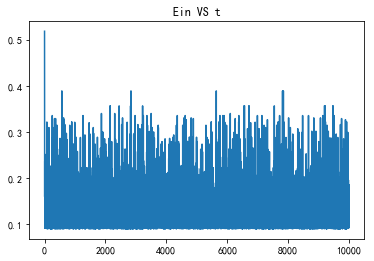

In [22]:
t=np.arange(num)
plt.plot(t,np.array(error)/data.shape[0])
plt.title('Ein VS t')
plt.show()

从Pocket PLA的算法里我们可以看到$E_{in}$可能会波动很大，上图也证实了这点

(c)的图

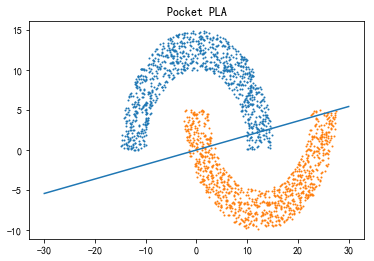

PLA的错误率0.089


In [23]:
plt.scatter(X1,Y1,s=1)
plt.scatter(X2,Y2,s=1)
t=2*(rad+thk)
X3=[-t,t]
Y3=[-(w[0]+w[1]*i)/w[2] for i in X3]
plt.plot(X3,Y3)
plt.title('Pocket PLA')
plt.show()
print('PLA的错误率'+str(CountError(data,w)/data.shape[0]))

(d)linear regression，之前有处理过，直接带公式即可

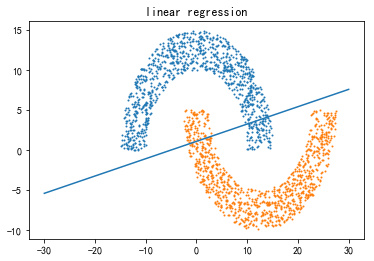

linear regression的错误率0.092


In [24]:
#对数据预处理
x1=[[1]+i for i in top]
y1=[1]*len(top)

x2=[[1]+i for i in bottom]
y2=[-1]*len(bottom)

X=np.array(x1+x2)
Y=np.array(y1+y2)

w1=inv(X.T.dot(X)).dot(X.T).dot(Y)

#作图
t=2*(rad+thk)
X4=[-t,t]
Y4=[-(w1[0]+w1[1]*i)/w1[2] for i in X4]

plt.scatter(X1,Y1,s=1)
plt.scatter(X2,Y2,s=1)
plt.plot(X4,Y4)
plt.title('linear regression')
plt.show()
print('linear regression的错误率'+str(CountError(data,w1)/data.shape[0]))

(e)先做三次特征转换，再重复(b)到(d)，注意到三次特征转换为
$$
\phi_3(x)=(1,x_1,x_2,x_1x_2,x_1^2,x_2^2,x_1^3,x_1^2x_2,x_1x_2^2,x_2^3)
$$
后续作曲线的图用到了plt.contour函数，原本是用来绘制等高线的，这里可以用来画隐函数的图像

In [25]:
#data形式为[  1.        ,   3.05543009,  -3.72519952,  -1.        ]
#特征转换
def transform(data):
    result=[]
    for i in data:
        x1=i[1]
        x2=i[2]
        flag=i[-1]
        x=[1,x1,x2,x1*x2,x1**2,x2**2,x1**3,(x1**2)*x2,x1*(x2**2),x2**3,flag]
        result.append(x)
    return np.array(result)

newdata=transform(data)

# 定义等高线高度函数
def f(x,y,w):
    return w[0]+w[1]*x+w[2]*y+w[3]*x*y+w[4]*(x**2)+w[5]*(y**2)+w[6]*(x**3)+w[7]*(x**2)*y+w[8]*x*(y**2)+w[9]*y**3

# 数据数目
n = 2000
# 定义x, y
x = np.linspace(-t, t, n)
y = np.linspace(-t, t, n)

# 生成网格数据
X, Y = np.meshgrid(x, y)

将转换过的数据带入Pocket PLA

In [26]:
#迭代次数
num=10000

w,error=PocketPLA(newdata,1,num)

作图

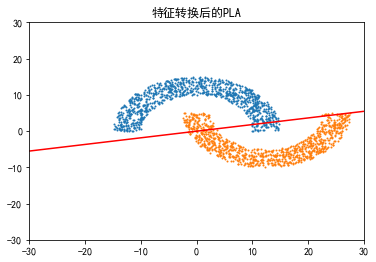

特征转换后的错误率为0.089


In [27]:
plt.contour(X, Y, f(X, Y,w), 1, colors = 'red')
plt.scatter(X1,Y1,s=1)
plt.scatter(X2,Y2,s=1)
plt.title('特征转换后的PLA')
plt.show()
print('特征转换后的错误率为'+str(CountError(newdata,w)/newdata.shape[0]))

将转换后的数据带入linear regression

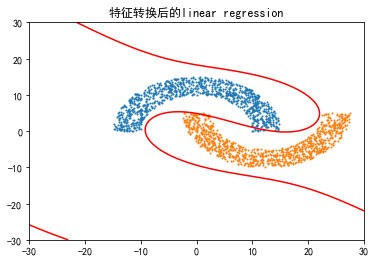

特征转换后的错误率为0.009


In [28]:
#对数据预处理
Xnew=newdata[:,:-1]
Ynew=newdata[:,-1]

w1=inv(Xnew.T.dot(Xnew)).dot(Xnew.T).dot(Ynew)

plt.contour(X, Y, f(X, Y,w1), 1, colors = 'red')
plt.scatter(X1,Y1,s=1)
plt.scatter(X2,Y2,s=1)
plt.title('特征转换后的linear regression')
plt.show()
print('特征转换后的错误率为'+str(CountError(newdata,w1)/newdata.shape[0]))

#### Problem 3.4 (Page 110)

In Problem 1.5, we introduced the Adaptive Linear Neuron (Ada line) algorithm for classification. Here, we derive Ada line from an optimization perspective.

 (a) Consider $E_n (w) = (\max(0, 1 - y_nw^Tx_n))^2$ . Show that $E_n (w)$ is continuous and differentiable. Write down the gradient $\nabla E_n (w)$ . 

(b) Show that $E_n (w)$ is an upper bound for $[\![sign(w^Tx_n) \ne y_n]\!] $. Hence, $\frac 1N \sum_{n=1}^N E_n (w) $is an upper bound for the in sample classification error $E_{in} (w)$ . 

(c) Argue that the Adaline algorithm in Problem 1.5 performs stochastic gradient descent on $\frac 1N \sum_{n=1}^N E_n (w) $ .    

(a)$1 - y_nw^Tx_n$关于$w$是连续的，$max(a,x)$关于x是连续的，所以$\max(0, 1 - y_nw^Tx_n)$关于$w$是连续的，连续函数的平方也是连续的，所以$E_n (w) = (\max(0, 1 - y_nw^Tx_n))^2$ 关于$w$连续。再来看可导性，令$s(w)=1 - y_nw^Tx_n$,$s(w)$显然关于$w$可导性,我们再来看下$f(s)=(max(0,s))^2$
$$
f(s)=\begin{cases}
s^2(s\ge0)
\\0(s<0)
\end{cases}
$$
显然这个函数也是可导的。所以$E_n (w)=f(s(w))$也可导。接下来我们求梯度
$$
\frac{\partial E_{n(w)}}{w_k}
=\begin{cases}
\frac{\partial (1 - y_nw^Tx_n)^2}{\partial w_k}=(1 - y_nw^Tx_n)(-y_nx_n^k)\qquad\ (y_nw^Tx_n\le1)
\\0\qquad\qquad\qquad\qquad\qquad\qquad\qquad\ ( y_nw^Tx_n>1)
\end{cases}
$$
因此
$$
\nabla E_n (w) =\begin{cases}
(1 - y_nw^Tx_n)(-y_nx_n)\qquad\ \ \ \ (y_nw^Tx_n\le1)
\\0 \qquad\qquad\qquad\qquad\qquad(y_nw^Tx_n>1)
\end{cases}
$$
(b)作图，我们先对式子做点变形
$$
[\![sign(w^Tx_n) \ne y_n]\!]  \Leftrightarrow
\\ [\![y_n\times sign(w^Tx_n) \ne y_n\times y_n]\!] \Leftrightarrow
\\ [\![sign(y_nw^Tx_n) \ne1]\!]
$$
令$s=sign(y_nw^Tx_n)$

说以上述两个式子可以化为$(max(0,1-s))^2$以及$[\![sign(s) \ne1]\!]$

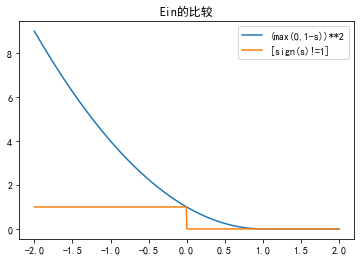

In [34]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

def f1(s):
    a=max(0,1-s)
    return a**2

def f2(s):
    if s>0:
        return 0
    else:
        return 1
    
x=np.linspace(-2,2,500)
y1=[f1(i) for i in x]
y2=[f2(i) for i in x]

plt.plot(x,y1,label="(max(0,1-s))**2")
plt.plot(x,y2,label="[sign(s)!=1]")
plt.legend()
plt.title('Ein的比较')
plt.show()

(c)回顾Problem 1.5的更新规则
$$
s(t) = w^T(t)x(t),当y(t) · s(t) \le 1时
\\w(t + 1) = w(t) + \eta (y(t)-s(t)).x(t)
$$
再来看下我们的梯度，稍微做下变形
$$
(1 - y_nw^Tx_n)(-y_nx_n)=-(y_n-w^Tx_n)x_n
\\\nabla E_n (w) =\begin{cases}
-(y_n-w^Tx_n)x_n\qquad\ \ \ \ (y_nw^Tx_n\le1)
\\0 \qquad\qquad\qquad\qquad(y_nw^Tx_n>1)
\end{cases}
$$
所以随机梯度下降法的更新规则为
$$
w(t + 1) 
= w(t) -\eta\nabla E_n (w) 
=\begin{cases}
w(t)+\eta(y_n-w(t)^Tx_n)x_n\qquad\ \ \ (y_nw(t)^Tx_n\le1)
\\w(t) \qquad\qquad\qquad\qquad\qquad(y_nw(t)^Tx_n>1)
\end{cases}
$$
我们使用Problem 1.5一样的符号$s(t) = w^T(t)x(t)$，那么随机梯度下降法的更新规则即为Problem 1.5的更新规则

#### Problem 3.5 (Page 110)

(a) Consider
$$
E_n (w) = \max(0, 1 - y_nw^Tx_n)
$$
Show that $E_n (w)$ is continuous and differentiable except when $y_n = w^Tx_n$ . 

(b) Show that $E_n(w)$ is an upper bound for $[\![sign(w^Tx_n) \ne y_n]\!]$. Hence, $\frac 1N \sum_{n=1}^N E_n (w) $is an upper bound for the in sample classification error $E_{in} (w)$ . 

(c) Apply stochastic gradient descent on $\frac 1N \sum_{n=1}^N E_n (w) $(ignoring the singular case of $y_n = w^Tx_n$) and derive a new perceptron learning algorithm.    

(a)我们用上一题一样的思路，令$s= y_nw^Tx_n$，$f(s)=max(0,1-s)$关于$s$连续,$s$关于$w$连续，因此$E_n (w)=f(s(w))$关于$w$连续。

$s$关于$w$处处可导，但$f(s)=max(0,1-s)$在$s=1$处不可导，其余点均可导。我们来看下$s=1$的特点，注意$y_n\in\{1,-1\}$，那么
$$
s=1\Leftrightarrow
\\y_nw^Tx_n=1\Leftrightarrow
\\y_n\times y_nw^Tx_n=y_n\Leftrightarrow
\\w^Tx_n=y_n
$$
所以$E_n (w)=f(s(w))$在$s=1$即$y_n = w^Tx_n$处不可导，其余点均可导

(b)同Problem 3.4方法，$s= y_nw^Tx_n$
$$
E_n (w) = \max(0, 1 - y_nw^Tx_n)=max(0,1-s)
\\ [\![sign(s) \ne 1]\!]
$$


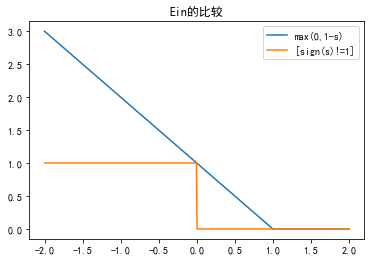

In [36]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

def f1(s):
    a=max(0,1-s)
    return a

def f2(s):
    if s>0:
        return 0
    else:
        return 1
    
x=np.linspace(-2,2,500)
y1=[f1(i) for i in x]
y2=[f2(i) for i in x]

plt.plot(x,y1,label="max(0,1-s)")
plt.plot(x,y2,label="[sign(s)!=1]")
plt.legend()
plt.title('Ein的比较')
plt.show()

(c)不管不可导点，我们来求梯度，只考虑$ y_nw^Tx_n<1$的情形，此时
$$
E_n (w) = 1 - y_nw^Tx_n
\\\frac{\partial E_n (w) }{\partial w_i}
=\frac{\partial (1 - y_nw^Tx_n) }{\partial w_i}=-y_nx_n^i
$$
所以
$$
当y_nw^Tx_n<1时，\nabla E_n (w)=-y_nx_n
\\当y_nw^Tx_n\ge1时，\nabla E_n (w)=0
$$
所以SGD（随机梯度下降法）的更新规则为
$$
当y_nw(t)^Tx_n<1时
\\w(t+1)=w(t)-\eta\nabla E_n (w)=w(t)+\eta y_nx_n
\\当y_nw(t)^Tx_n\ge1时不更新
$$
